<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/7.Controller-tuning/Sintonia_de_controladores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar e importas as bibliotecas necessárias

In [ ]:
! pip install -qq control

In [ ]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# Definir o modelo do processo

In [ ]:
s = ct.tf('s')
K, tau1, tau2, theta = 2.0, 10., 5., 1
G_ = K/((tau1*s+1)*(tau2*s+1)) * ct.tf(*ct.pade(theta,10,5))

# Implementar a malha fechada

Sintonia -> Kc=2.500 tauI=15.000 tauD=3.333 
Sintonia -> Kc=1.250 tauI=15.000 tauD=3.333 
Sintonia -> Kc=0.682 tauI=15.000 tauD=3.333 


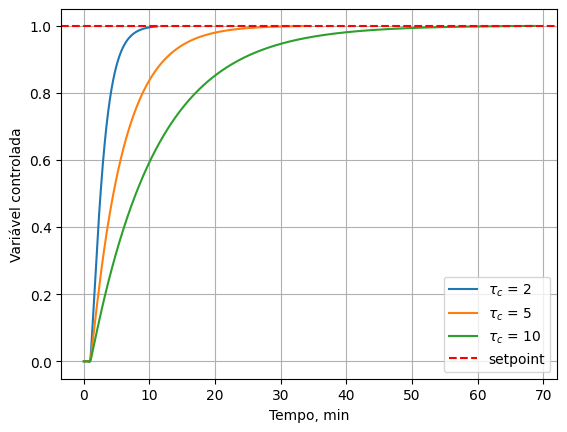

In [ ]:
# Parâmetro do controlador
par = [2, 5, 10]

# Simulação
for tauc in par:

  # Sintonia via método DS
  Kc = (tau1+tau2)/(K*(tauc+theta))
  tauI = tau1 + tau2
  tauD = tau1*tau2/(tau1 + tau2)
  print(f'Sintonia -> Kc={Kc:1.3f} tauI={tauI:1.3f} tauD={tauD:1.3f} ')

  # Controlador
  Gc = Kc*(1 + 1/(tauI*s) + tauD*s)

  # Malha fechada
  G_servo = ct.minreal(Gc*G_/(1+Gc*G_), verbose=False)

  # Teste servo
  ts, ys = ct.step_response(G_servo)

  # Visualizar
  plt.plot(ts,ys, label = r'$\tau_c$ = ' + f'{tauc}')

plt.axhline(y=1,linestyle='--', color='r', label='setpoint')
plt.xlabel('Tempo, min')
plt.ylabel('Variável controlada')
plt.legend()
plt.grid()